# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

#### Import the libraries

In [1]:
# General libraries:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import OrderedDict
from PIL import Image

# Pytorch library:
import torch
from torchvision import transforms, datasets, models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

**Student comment:**<br>
This notebook will be written using as many functions as needed to make it easier to build an app later, since it is required on the second part of the project.

#### Set directories

In [2]:
def set_dir(data_dir):
    """
    Function to set the dataset directories, which are stored inside the data_dir folder.
    """
    data_map = dict()
    data_map['train'] = os.path.join(data_dir, 'train')    
    data_map['test'] = os.path.join(data_dir, 'test')    
    data_map['valid'] = os.path.join(data_dir, 'valid')        
    return data_map

In [3]:
# Check run:
data_map = set_dir('data')

for key in data_map:
    print("Folder of {:>6} dataset is '{}'.".format(key, data_map[key]))

Folder of  train dataset is 'data\train'.
Folder of   test dataset is 'data\test'.
Folder of  valid dataset is 'data\valid'.


#### TODO: Define your transforms for the training, validation, and testing sets

In [4]:
# Normalization paremeters used by the pre-trained network:
MEANS = [0.485, 0.456, 0.406]
STDEV = [0.229, 0.224, 0.225]

In [5]:
def set_transforms():
    """
    Set the transforms for all datasets.
    """
    #
    data_transforms = dict()
    data_transforms['train'] = transforms.Compose([transforms.RandomRotation(30),
                                                   transforms.RandomResizedCrop(224),
                                                   transforms.RandomHorizontalFlip(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(MEANS, STDEV)])
    #
    data_transforms['test'] = transforms.Compose([transforms.Resize(256),
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(MEANS, STDEV)])
    #
    data_transforms['valid'] = data_transforms['test']
    #
    return data_transforms

In [6]:
# Check run:
data_transforms = set_transforms()

for key in data_transforms:
    print("\n> DATA TRANSFORM FOR: '{}'".format(key))
    print(data_transforms[key])


> DATA TRANSFORM FOR: 'train'
Compose(
    RandomRotation(degrees=(-30, 30), resample=False, expand=False)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

> DATA TRANSFORM FOR: 'test'
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

> DATA TRANSFORM FOR: 'valid'
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


#### TODO: Load the datasets with ImageFolder

In [7]:
#dict_variable = {key:value for (key,value) in dictonary.items()}
def load_datasets():
    """
    Load the datasets with ImageFolder.
    """
    image_datasets = dict()
    #
    for key, value in data_map.items():
        image_datasets[key] = datasets.ImageFolder(value, transform=data_transforms[key])
    #
    return image_datasets    

In [8]:
# Check run:
image_datasets = load_datasets()

for key in image_datasets:
    print("\n> IMAGE DATASET FOR: '{}'".format(key))
    print(image_datasets[key])


> IMAGE DATASET FOR: 'train'
Dataset ImageFolder
    Number of datapoints: 6552
    Root location: data\train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

> IMAGE DATASET FOR: 'test'
Dataset ImageFolder
    Number of datapoints: 819
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

> IMAGE DATASET FOR: 'valid'
Dataset ImageFolder
    Number of datapoints: 818
    Root location: data

#### TODO: Using the image datasets and the transforms, define the dataloaders

In [9]:
# Set the batch size as a variable, to make it easY to change:
nbatch = 32

In [10]:
def set_dataloaders():
    """
    Define the dataloaders using image datasets and transforms.
    """
    dataloaders = dict()
    #
    for key in data_map:
        dataloaders[key] = torch.utils.data.DataLoader(image_datasets[key], batch_size=nbatch, shuffle=True)
    #
    return dataloaders

In [11]:
# Check run:
dataloaders = set_dataloaders()

for key in dataloaders:
    print("\n> DATALOADER FOR: '{}'".format(key))
    print(dataloaders[key])


> DATALOADER FOR: 'train'

> DATALOADER FOR: 'test'

> DATALOADER FOR: 'valid'


#### Take a look at images from each dataset to check if it was loaded correctly:

In [12]:
def imshow(image, mean_list, stdv_list, ax=None, title=None, normalize=True):
    """
    Function adapted from Udacity's Introduction to Machine Learning Nanodegree material (helper.py).
    """
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array(mean_list)
        std = np.array(stdv_list)
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

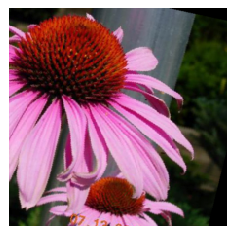

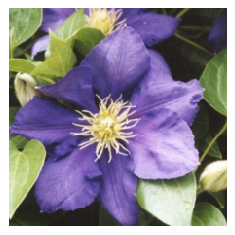

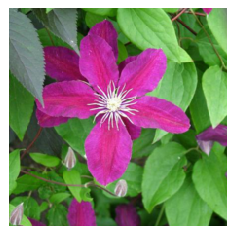

In [13]:
# Take a look at one image from each dataset:
for key in data_map:    
    images, labels = next(iter(dataloaders[key]))    
    imshow(images[0], MEANS, STDEV)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [14]:
# Load the mapping from label to category:
def load_cat_map(map_file):
    """
    Load category map form a json file.
    """
    with open(map_file, 'r') as f:
        cat_to_name = json.load(f)
    return cat_to_name

In [15]:
# Check run:
cat_to_name = load_cat_map('cat_to_name.json')

In [16]:
# Number of categories
ncat = len(cat_to_name)
ncat

102

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

#### TODO: Build and train your network

In [17]:
#
# Build the neural network
#

In [18]:
# Set some variables:
dropout = 0.5
choice = "vgg16"
hidden_user = [4096, 1024]
learning_rate = 0.001
epochs = 12

In [19]:
def build(choice, hidden_user, ncat):
    """
    Build the neural network
    """
    #
    # Choose the pretrained network from torch.vision.modules:  
    #   
    if choice == "vgg16":
        model = models.vgg16(pretrained=True)
        ninp = 25088
    elif choice == "densenet121":
        model = models.densenet121(pretrained=True)
        ninp = 1024
    else:
        # There is a lot of room to future improvement
        print("Model {} not available.")
        print("Only 'vgg16' and 'densenet121' are available.")
        print("Moving forward with 'vgg16'.".format(choice))
        model = models.vgg16(pretrained=True)
        ninp = 25088
    #
    # Freeze the parameters of the pre-trained network, otherwise the algorithm will backpropagate to them:
    #
    for parameters in model.parameters():
        parameters.requires_grad = False
    #
    # Set the classifier architecture according to the chosen parameters:
    #
    hidden_units = [ninp] + hidden_user + [ncat]
    # Hidden layers:
    clf_dict = OrderedDict()    
    for i in range(len(hidden_units) - 2):        
        clf_dict['h' + str(i)] = torch.nn.Linear(hidden_units[i], hidden_units[i+1])
        clf_dict['f' + str(i)] = torch.nn.ReLU()
        clf_dict['d' + str(i)] = torch.nn.Dropout(dropout)    
    # Output layer:
    clf_dict['hout'] = torch.nn.Linear(hidden_units[i+1], ncat)
    clf_dict['fout'] = torch.nn.LogSoftmax(dim=1)
    # Set the model classifier
    classifier = torch.nn.Sequential(clf_dict)
    model.classifier = classifier
    #
    return(model)

In [20]:
# Check run:
model = build(choice, hidden_user, ncat)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# Set the loss function:
criterion = torch.nn.NLLLoss()

In [22]:
# Set the optimizer. Take care to train only the classifier parameters.
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [23]:
# Check if CUDA is available, if not, will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def train():
    """
    Train the model.
    """
    start = time.time()
    # Copy the model to the available device (CPU or GPU):    
    model.to(device)
        
    step = 0
    for epoch in range(epochs):
        running_loss = 0.0
        # Train the model classifier:
        for inputs, labels in dataloaders['train']:
            # Increment the current step:
            step += 1        
            # Move inputs and labels to the available device (CPU or GPU):
            inputs, labels = inputs.to(device), labels.to(device)
            # Reset the optimizer to zero, otherwise it will accumulate:
            optimizer.zero_grad()  
            # Feed forward the model
            log_prob = model.forward(inputs)
            # Evaluate the loss function:
            loss = criterion(log_prob, labels)
            # Backpropagate the loss:
            loss.backward()
            # Update the parameters:
            optimizer.step()
            # Update the loss:
            running_loss += loss.item()
        
            # Display validation loss and accuracy:
            if step % nbatch == 0:
                # Set the model to the evaluation mode:
                model.eval()
                # Initialize loss and accuracy:
                valid_loss = 0.0
                accuracy = 0.0            
                            
                # Will not calculate gradients, so turn off the gradients to improve performance:
                with torch.no_grad():
                    for inputs2, labels2 in dataloaders['valid']:                        
                        # Move inputs and labels to the available device (CPU or GPU):
                        inputs2, labels2 = inputs2.to(device), labels2.to(device)
                        # Feed forward the model:
                        log_prob2 = model.forward(inputs2)
                        # Evaluate the loss function:
                        batch_loss = criterion(log_prob2, labels2)
                        # Update the validation loss:
                        valid_loss += batch_loss.item()                    
                        # Since we are using the LogSoftmax function as output, we have to exponentiate
                        # the output to get the correct values:
                        probabilities = torch.exp(log_prob2)                    
                        # Get the top probability and classs
                        top_prob, top_class = probabilities.topk(1, dim=1)                    
                        # Get a tensor with 1 when class matches with prediction and 0 otherwise
                        equals = top_class == labels2.view(*top_class.shape)
                        # Update the accuracy of the validation data:
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                        
                # Display the loss and accuracy on the validation set
                # Rubric requires: "During training, the validation loss and accuracy are displayed."
                print("Epoch: {:02d}".format(epoch+1), end='/')
                print("{:02d}".format(epochs), end=', ')                    
                print("Train loss: {:0.3f}".format(running_loss/nbatch), end=', ')
                print("Validation loss: {:0.3f}".format(valid_loss/len(dataloaders['valid'])), end=', ')
                print("Validation accuracy: {:0.3f}".format(accuracy/len(dataloaders['valid'])), end=', ')
                # Show elapsed time:
                dt = time.time() - start
                dt = dt/60
                print("Elapsed Time: {:6.1f}min".format(dt))
                
                # Set the model to training mode:
                model.train()
                
                # Zero the running_loss:
                running_loss = 0.0

In [25]:
#
# Finally, train the model: 
#
start = time.time()
#
train()
#
ttime = (time.time() - start)/60
print("Total elapsed time: {:3.1f}min".format(ttime))

Epoch: 01/12, Train loss: 4.830, Validation loss: 4.027, Validation accuracy: 0.200, Elapsed Time:    0.5min
Epoch: 01/12, Train loss: 3.965, Validation loss: 3.140, Validation accuracy: 0.275, Elapsed Time:    1.0min
Epoch: 01/12, Train loss: 3.522, Validation loss: 2.496, Validation accuracy: 0.395, Elapsed Time:    1.5min
Epoch: 01/12, Train loss: 3.065, Validation loss: 2.245, Validation accuracy: 0.442, Elapsed Time:    1.9min
Epoch: 01/12, Train loss: 2.971, Validation loss: 1.855, Validation accuracy: 0.522, Elapsed Time:    2.4min
Epoch: 01/12, Train loss: 2.710, Validation loss: 1.702, Validation accuracy: 0.549, Elapsed Time:    2.9min
Epoch: 02/12, Train loss: 1.381, Validation loss: 1.519, Validation accuracy: 0.591, Elapsed Time:    3.3min
Epoch: 02/12, Train loss: 2.490, Validation loss: 1.408, Validation accuracy: 0.624, Elapsed Time:    3.7min
Epoch: 02/12, Train loss: 2.455, Validation loss: 1.407, Validation accuracy: 0.618, Elapsed Time:    4.2min
Epoch: 02/12, Train

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

#### TODO: Do validation on the test set

In [26]:
accuracy = 0.0
test_loss = 0.0
model.eval()

for inputs, labels in dataloaders['test']:
    with torch.no_grad():
        # Move inputs and labels to the available device (CPU or GPU):
        inputs, labels = inputs.to(device), labels.to(device)
        # Feed forward the model:
        log_prob = model.forward(inputs)
        # Evaluate the loss function:
        batch_loss = criterion(log_prob, labels)
        # Update the test loss:
        test_loss += batch_loss.item()
        # Since we are using the LogSoftmax function as output, we have to exponentiate
        # the output to get the correct values:        
        probabilities = torch.exp(log_prob)
        # Get the top probability and classs
        top_prob, top_class = probabilities.topk(1, dim=1)
        # Get a tensor with 1 when class matches with prediction and 0 otherwise
        equals = top_class == labels.view(*top_class.shape)
        # Update the accuracy of the test data:
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
# Display loss and accuracy for the test data:
print("Test loss: {:0.3f}".format(test_loss/len(dataloaders['test'])), end=' ,')                        
print("Test accuracy: {:0.3f}".format(accuracy/len(dataloaders['test'])))

Test loss: 0.918 ,Test accuracy: 0.770


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

#### TODO: Save the checkpoint 

In [27]:
model.class_to_idx =  image_datasets['train'].class_to_idx
#
model_dict = dict()
model_dict['pre_trained'] = choice
model_dict['hidden_user'] = hidden_user
model_dict['ncat'] = ncat
model_dict['model_state_dict'] = model.state_dict() # Includes the dropout
#model_dict['optimizer_state_dict'] = optimizer.state_dict() # Includes the learning rate
model_dict['class_to_idx'] = model.class_to_idx
# Save the model to file.
torch.save(model_dict, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

#### TODO: Write a function that loads a checkpoint and rebuilds the model

In [28]:
def load_checkpoint(chk_file="checkpoint.pth"):
    """
    Load the model from a saved checkpoint file.
    """
    try:
        checkpoint = torch.load(chk_file, map_location='cpu')
    except:
        print("Could not load checkpoint from file: '{}'.".format(chk_file))
        print("Please check and try again.")
        model = None
    else:        
        choice = checkpoint["pre_trained"]
        hidden_user = checkpoint["hidden_user"]
        ncat = checkpoint["ncat"]
        model = build(choice, hidden_user, ncat)
        model = model.to(torch.device('cpu'))
        #
        model.load_state_dict(checkpoint["model_state_dict"])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.class_to_idx = checkpoint["class_to_idx"]
    return model

In [29]:
# Check run:
model = load_checkpoint()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

#### TODO: Process a PIL image for use in a PyTorch model

In [30]:
def process_image(img):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model, returns an Numpy array
    """
    pil_img = Image.open(img)   
    img_transform = data_transforms['test']
    torch_img = img_transform(pil_img)    
    return torch_img   

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [31]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(MEANS)
    std = np.array(STDEV)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

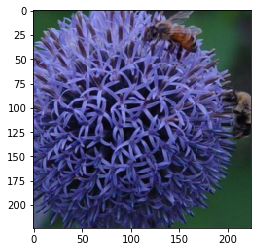

In [32]:
img_path = "data/test/10/image_07090.jpg"

imshow(process_image(img_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

#### TODO: Implement the code to predict the class from an image file

In [33]:
# Create a reversed dictionary from index to class:
idx_to_class = dict(zip(model.class_to_idx.values(), model.class_to_idx.keys()))

In [34]:
def predict(image_path, dev_run, chk_file="checkpoint.pth", topk=5):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    # Process the image
    imgtorch = process_image(image_path)
    imgtorch = imgtorch.unsqueeze_(0)    
    #imgtorch = imgtorch.float()
        
    # Select the device to run the prediciton:    
    if dev_run == "gpu":
        if torch.cuda.is_available():
            dev = torch.device("cuda")
            print("Proceeding with GPU.")
        else:
            print("GPU is not available, proceeding with CPU.")
            dev = torch.device("cpu")
    else:
        print("Proceeding with CPU.")
        dev = torch.device("cpu")

    # Load the file from a checkpoint, as required.
    model = load_checkpoint(chk_file)  
    
    # Move the model to the device
    model = model.to(dev)
    imgtorch = imgtorch.to(dev)
    
    # Set the evaluaton mode on    
    model.eval()
    # Predict
    with torch.no_grad():
        log_pred = model.forward(imgtorch)
        # Get the probabilities
        probabilities = torch.exp(log_pred)
        # Get the top probability and classs
        top_prob, top_class = probabilities.topk(topk, dim=1)
        
    return top_prob, top_class

In [35]:
# Check run:
probs, classes = predict(img_path, "gpu", topk=5)

# Print probs and classes, as required.
print(probs)
print(classes)

Proceeding with GPU.
tensor([[9.9954e-01, 1.5954e-04, 1.3990e-04, 8.4662e-05, 2.5506e-05]],
       device='cuda:0')
tensor([[ 1, 17,  8, 24, 34]], device='cuda:0')


In [36]:
# Show the name of the predicted class:
classes_np = classes.cpu()
ix = idx_to_class[classes_np.numpy()[0][0]]
cat_to_name[ix]

'globe thistle'

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

#### TODO: Display an image along with the top 5 classes

In [37]:
def view_classify(img=img_path):
    """
    Function adapted from Udacity's Introduction to Machine Learning Nanodegree material (helper.py).
    """
    plt.rcdefaults()
    fig, (ax1, ax2) =  plt.subplots(2,1, figsize=(8,8))
    #
    # Plot the image,se CPU, because numpy is not available on GPUs
    #
    img_np = process_image(img)
    image = img_np.numpy().transpose((1, 2, 0))    
    mean = np.array(MEANS)
    std = np.array(STDEV)
    image = std * image + mean    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax1.imshow(image)
    
    #
    # Plot the probabilities:
    # 
    ps, cls = predict(img, "cpu", topk=5)       
    ps = ps.cpu().data.numpy().squeeze().tolist()
    cls = cls.cpu().data.numpy()[0].tolist()    
    str_cls = [cat_to_name[idx_to_class[v]] for v in cls]
    str_ps = [str(v)[:5] for v in ps]
    #    
    y_pos = np.arange(len(str_cls)) # Y POSITIONS
    #
    ax2.barh(y_pos, ps, align='center', color='skyblue', ecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(str_cls, fontsize=8)
    ax2.set_xlabel('Classes Propabilities', fontsize=12)
    ax2.set_ylabel('Predicted Classes', fontsize=12)
    ax2.set_title('Predicted Classes X Probabilities', fontsize=14)
    ax2.invert_yaxis()  # labels read top-to-bottom
    #
    for j,i in enumerate(ax2.patches):    
        ax2.text(i.get_x()+.005, i.get_y()+.5, str_ps[j], fontsize=10, color='black')  

    #
    # Figure title
    #
    
    classes_np = classes.cpu()
    ix = idx_to_class[classes_np.numpy()[0][0]]
        
    ax1.set_title(cat_to_name[ix].upper(), fontsize=14)    
    plt.tight_layout() # Increase de figures sapacing
    
    plt.show()    

Proceeding with CPU.


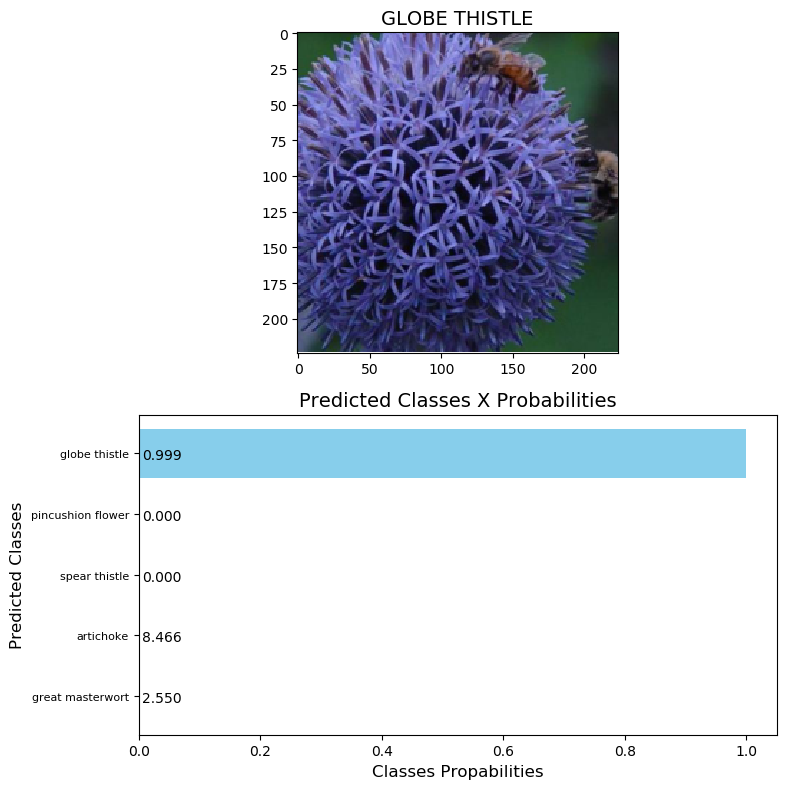

In [38]:
view_classify("data/test/10/image_07090.jpg")